<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/cubes/cubes_Silhouette_validation_DINOV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# אימון

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import silhouette_score
import torchvision.transforms as T
import timm

# === 1. טעינת המודל החדש ===
model = timm.create_model('vit_large_patch14_dinov2.lvd142m', pretrained=True, num_classes=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# === 2. הגדרת טרנספורמציות ===
data_config = timm.data.resolve_model_data_config(model)
default_transform = timm.data.create_transform(**data_config, is_training=False)

class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224 / w, 224 / h, 1.0)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB", (224, 224))
        canvas.paste(img, ((224 - new_w) // 2, (224 - new_h) // 2))
        return default_transform(canvas)

def resize_and_pad(size):
    class ResizeAndPad:
        def __call__(self, img):
            img = img.resize((size, size), Image.BICUBIC)
            canvas = Image.new("RGB", (224, 224))
            canvas.paste(img, ((224 - size) // 2, (224 - size) // 2))
            return default_transform(canvas)
    return ResizeAndPad()

class Duplicate2x2Grid:
    def __call__(self, img):
        w, h = img.size
        grid = Image.new("RGB", (w * 2, h * 2))
        for i in range(2):
            for j in range(2):
                grid.paste(img, (i * w, j * h))
        return default_transform(grid.resize((224, 224), Image.BICUBIC))

transforms_dict = {
    "pad_center_224": PadToCenter224(),
    "resize_224": default_transform,
    "resize_50_pad": resize_and_pad(50),
    "resize_100_pad": resize_and_pad(100),
    "resize_150_pad": resize_and_pad(150),
    "resize_200_pad": resize_and_pad(200),
    "grid_2x2": Duplicate2x2Grid(),
}

# === 3. פונקציות עזר ===
def get_image_paths(dirpath):
    out = []
    for cl in os.listdir(dirpath):
        cp = os.path.join(dirpath, cl)
        if os.path.isdir(cp):
            out += [os.path.join(cp, f)
                    for f in os.listdir(cp)
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    return out

def extract_embeddings(paths, transform):
    X, y = [], []
    with torch.no_grad():
        for p in tqdm(paths):
            img = Image.open(p).convert("RGB")
            tensor_img = transform(img).unsqueeze(0).to(device)
            feats = model.forward_features(tensor_img)
            pooled = model.forward_head(feats, pre_logits=True)
            X.append(pooled.squeeze().cpu().numpy())
            y.append(os.path.basename(os.path.dirname(p)))
    return np.array(X), np.array(y)

def compute_sep(X, y):
    centroids = [X[y == c].mean(0) for c in np.unique(y)]
    dists = [np.linalg.norm(centroids[i] - centroids[j])
             for i in range(len(centroids))
             for j in range(i)]
    return np.mean(dists)

# === 4. הרצת טרנספורמציות והפקת תוצאות ===
train_paths = get_image_paths("/content/drive/MyDrive/cubes_new/cubes_train")
results_train = []
train_embeddings = {}

for name, tf in transforms_dict.items():
    print(f"\n🔄 Processing transform: {name}")
    X, y = extract_embeddings(train_paths, tf)
    train_embeddings[name] = (X, y)
    sil = silhouette_score(X, y)
    sep = compute_sep(X, y)
    results_train.append({"Transform": name, "Silhouette": sil, "Separation": sep})

df_train = pd.DataFrame(results_train).sort_values(by="Silhouette", ascending=False)
print("\n📊 Training Metrics:")
print(df_train.to_string(index=False, float_format="%.3f"))



🔄 Processing transform: pad_center_224


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]



🔄 Processing transform: resize_224


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]



🔄 Processing transform: resize_50_pad


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]



🔄 Processing transform: resize_100_pad


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]



🔄 Processing transform: resize_150_pad


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]



🔄 Processing transform: resize_200_pad


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]



🔄 Processing transform: grid_2x2


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


📊 Training Metrics:
     Transform  Silhouette  Separation
 resize_50_pad       0.100      22.546
pad_center_224       0.098      21.786
resize_100_pad       0.085      21.619
resize_150_pad       0.074      20.960
    resize_224       0.069      20.477
      grid_2x2       0.064      18.951
resize_200_pad       0.059      19.617


# ולידציה

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# הגדר מודלים ופרמטרים
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "NaiveBayes": (GaussianNB(), {})
}
chosen_transform_name = "resize_50_pad"
# טען נתוני אימון והמר labels
X_train, y_train = train_embeddings[chosen_transform_name]
val_paths = get_image_paths("/content/drive/MyDrive/cubes_new/cubes_val_new")
X_val, y_val = extract_embeddings(val_paths, transforms_dict[chosen_transform_name])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

val_results = []
best_params = {}

print(f"\nRunning validation for transform: {chosen_transform_name}")
for clf_name, (clf, grid) in classifiers.items():
    if grid:
        gs = GridSearchCV(clf, grid, cv=3, scoring="accuracy")
        gs.fit(X_train, y_train_enc)
        best = gs.best_estimator_
        best_params[clf_name] = gs.best_params_
    else:
        best = clf.fit(X_train, y_train_enc)
        best_params[clf_name] = {}

    y_pred = best.predict(X_val)
    acc = accuracy_score(y_val_enc, y_pred)
    min_cls = np.bincount(y_val_enc).argmin()
    f1_min = f1_score(y_val_enc, y_pred, labels=[min_cls], average="macro")

    val_results.append({
        "Model": clf_name,
        "Accuracy": acc,
        "F1_Minority": f1_min
    })

# הצגת טבלה מסכמת
df_val = pd.DataFrame(val_results)
df_val.set_index("Model", inplace=True)
print("\nValidation Results for transform:", chosen_transform_name)
print(df_val.round(3).to_string())
print("\nBest Parameters:")
for clf_name, params in best_params.items():
    print(f"{clf_name}: {params}")

100%|██████████| 140/140 [01:42<00:00,  1.37it/s]



Running validation for transform: resize_50_pad

Validation Results for transform: resize_50_pad
                    Accuracy  F1_Minority
Model                                    
LogisticRegression     0.700        0.753
SVM                    0.650        0.729
RandomForest           0.650        0.717
NaiveBayes             0.536        0.673

Best Parameters:
LogisticRegression: {'C': 0.01, 'penalty': 'l2'}
SVM: {'C': 1, 'gamma': 'scale'}
RandomForest: {'max_depth': 20, 'n_estimators': 100}
NaiveBayes: {}


# טסט

100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


<Figure size 600x500 with 0 Axes>

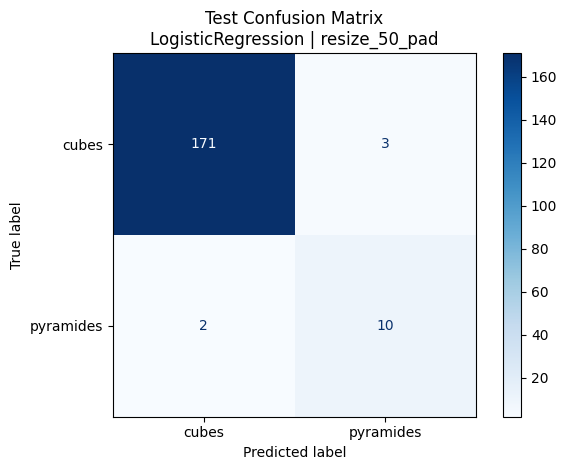


Classification Report for LogisticRegression | resize_50_pad:

              precision    recall  f1-score   support

       cubes       0.99      0.98      0.99       174
   pyramides       0.77      0.83      0.80        12

    accuracy                           0.97       186
   macro avg       0.88      0.91      0.89       186
weighted avg       0.97      0.97      0.97       186



In [ ]:
def evaluate_on_test(transform_name, model_name):
    tf = transforms_dict[transform_name]
    X_train, y_train = train_embeddings[transform_name]
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)

    clf, _grid = classifiers[model_name]
    params = best_params.get((model_name), {})
    clf.set_params(**params)
    clf.fit(X_train, y_train_enc)

    # test embeddings
    test_paths = get_image_paths("/content/drive/MyDrive/cubes_new/cubes_test")
    X_test, y_test = extract_embeddings(test_paths, tf)
    y_test_enc = le.transform(y_test)

    # Predictions
    y_pred = clf.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    plt.figure(figsize=(6,5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Test Confusion Matrix\n{model_name} | {transform_name}")
    plt.tight_layout()
    plt.show()

    # Classification Report
    report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
    print(f"\nClassification Report for {model_name} | {transform_name}:\n")
    print(report)
    return {
    "test_paths": test_paths,
    "y_test": le.inverse_transform(y_test_enc),
    "y_pred": le.inverse_transform(y_pred),
}


results = evaluate_on_test(chosen_transform_name, "LogisticRegression")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

def show_misclassified_images(test_paths, y_test, y_pred, max_images=10):
    """
    מציג תמונות שסווגו לא נכון עם תווית נכונה ותחזית.
    """
    print("❌ תמונות שסווגו לא נכון:\n")
    errors = 0

    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            image_path = test_paths[i]
            image_name = os.path.basename(image_path)
            print(f"🔸 {image_name}: predicted -> '{y_pred[i]}', label -> '{y_test[i]}'")

            # קריאת התמונה והצגה
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(3, 3))
                plt.imshow(image)
                plt.title(f"❌ {image_name}\npred: {y_pred[i]} | label: {y_test[i]}", fontsize=10)
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                errors += 1
                if errors >= max_images:
                    break
            else:
                print("⚠️ לא ניתן לטעון את התמונה:", image_path)

    if errors == 0:
        print("🎉 אין טעויות סיווג!")


❌ תמונות שסווגו לא נכון:

🔸 cubes_test_3_147_31_175.jpg: predicted -> 'pyramides', label -> 'cubes'


/tmp/ipython-input-10-3485315273.py:26: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


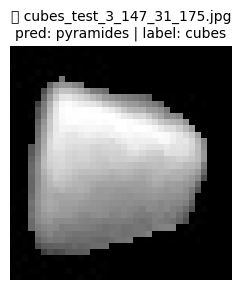

🔸 cubes_test_154_417_193_450.jpg: predicted -> 'pyramides', label -> 'cubes'


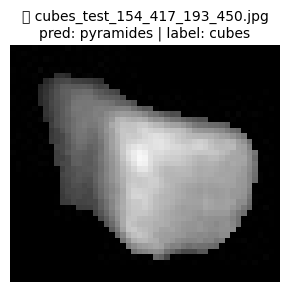

🔸 cubes_test_281_46_302_69.jpg: predicted -> 'pyramides', label -> 'cubes'


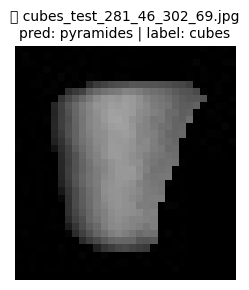

🔸 cubes_test_104_111_132_133.jpg: predicted -> 'cubes', label -> 'pyramides'


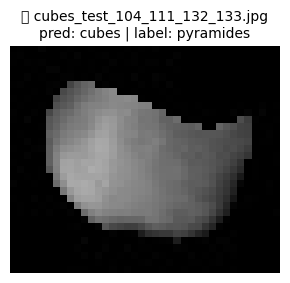

🔸 cubes_test_263_285_298_318.jpg: predicted -> 'cubes', label -> 'pyramides'


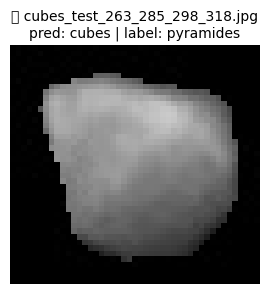

In [ ]:
show_misclassified_images(results["test_paths"], results["y_test"], results["y_pred"])


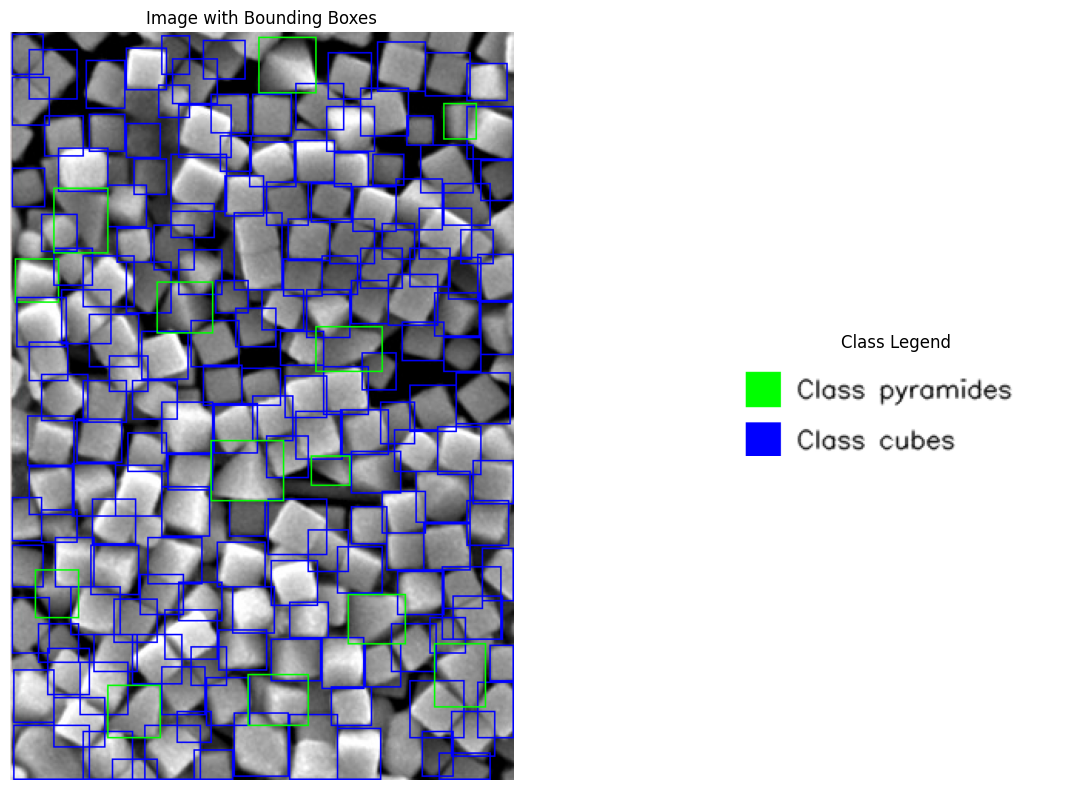

Saved image with bounding boxes to: /content/drive/MyDrive/predictions_with_bboxes.jpg


In [ ]:
def visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path):
    """
    מציירת תיבות סביב האובייקטים בתמונה לפי התחזיות של המודל.

    Parameters:
    - full_image_path: str, הנתיב לתמונה המלאה (background)
    - file_paths: list of str, מסלולים לתמונות החתוכות (שמות כוללים קואורדינטות)
    - predicted_labels: list of str/int, התחזיות (labels) של המודל
    - save_path: str, הנתיב לשמירת התמונה עם התיבות
    """
    import cv2
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    full_image = cv2.imread(full_image_path)
    image_copy = full_image.copy()
    pattern = re.compile(r"cubes_test_(\d+)_(\d+)_(\d+)_(\d+)\.jpg")

    unique_labels = list(set(predicted_labels))
    colors = {}

    color_palette = [
        (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
        (255, 0, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0),
    ]

    for i, label in enumerate(unique_labels):
        colors[label] = color_palette[i % len(color_palette)]

    legend_height = 30 * len(unique_labels)
    legend_width = 200
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.uint8) * 255

    for i, label in enumerate(unique_labels):
        color = colors[label]
        cv2.rectangle(legend_img, (10, i*30 + 10), (30, i*30 + 30), color, -1)
        cv2.putText(legend_img, f"Class {label}", (40, i*30 + 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    for file_path, label in zip(file_paths, predicted_labels):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            x1, y1, x2, y2 = map(int, match.groups())
            color = colors[label]
            overlay = image_copy.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 1)
            alpha = 1.4
            cv2.addWeighted(overlay, alpha, image_copy, 1 - alpha, 0, image_copy)

    cv2.imwrite(save_path, image_copy)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})
    ax[0].imshow(image_rgb)
    ax[0].set_title("Image with Bounding Boxes")
    ax[0].axis('off')

    ax[1].imshow(legend_rgb)
    ax[1].set_title("Class Legend")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved image with bounding boxes to: {save_path}")

full_image_path = "/content/drive/MyDrive/pictures_data/cubes_test.jpg"
file_paths = get_image_paths("/content/drive/MyDrive/cubes_new/cubes_test")
predicted_labels = results["y_pred"]
save_path = "/content/drive/MyDrive/predictions_with_bboxes.jpg"
visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path)